# Dream Club Loan Payment Prediction

In [1]:
# Import required libs
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read loan data-set
loan = pd.read_csv("loan_data.csv")

In [3]:
# Check some information related to the imported data-set
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Exploring the data-set (EDA) with plots and stats

In [4]:
# Check some information about data
print("""DataFrame Dimensions = {0}
Dataframe Shape = {1}""".format(loan.ndim, loan.shape))

DataFrame Dimensions = 2
Dataframe Shape = (9578, 14)


In [5]:
# Check column set
print(list(loan.columns))

['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']


In [6]:
# Rename columns to readable values
loan = loan.rename(columns={'credit.policy':'Policy', 'purpose':'Purpose', 'int.rate':'ROI', 'installment':'Installment',
                            'log.annual.inc':'Income', 'dti':'DTI', 'fico':'FICO', 'days.with.cr.line':'CreditLine',
                            'revol.bal':'Balance', 'revol.util':'Utilization', 'inq.last.6mths':'Inquiries',
                            'delinq.2yrs':'PastDueCount', 'pub.rec':'PublicRecord', 'not.fully.paid':'Default'})

In [7]:
# Make purpose as String and check data-types
loan.Purpose = loan.Purpose.astype('string', copy=False)
loan.dtypes

Policy            int64
Purpose          string
ROI             float64
Installment     float64
Income          float64
DTI             float64
FICO              int64
CreditLine      float64
Balance           int64
Utilization     float64
Inquiries         int64
PastDueCount      int64
PublicRecord      int64
Default           int64
dtype: object

In [8]:
# Check some samples of the data
loan.head(3)

,Policy,Purpose,ROI,Installment,Income,DTI,FICO,CreditLine,Balance,Utilization,Inquiries,PastDueCount,PublicRecord,Default
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0


In [9]:
# Check and drop duplicates
loan[loan.duplicated()]
# No duplicates found

,Policy,Purpose,ROI,Installment,Income,DTI,FICO,CreditLine,Balance,Utilization,Inquiries,PastDueCount,PublicRecord,Default


In [10]:
# Check null values
loan.isnull().sum()

Policy          0
Purpose         0
ROI             0
Installment     0
Income          0
DTI             0
FICO            0
CreditLine      0
Balance         0
Utilization     0
Inquiries       0
PastDueCount    0
PublicRecord    0
Default         0
dtype: int64

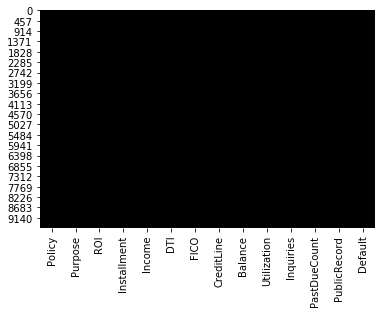

In [11]:
# NULL Values Using Heatmap
sb.heatmap(loan.isna(), cmap='CMRmap', cbar=False)
plt.show()
# The plot shows nothing as there are no missing values

In [12]:
# Check that Default is Integer 0/1
print(loan.Default.unique())

[0 1]


0    8045
1    1533
Name: Default, dtype: int64


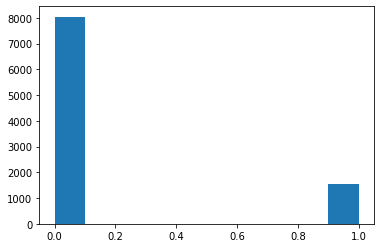

In [13]:
# Check class balance
print(loan.Default.value_counts())
plt.hist(loan.Default)
plt.show()
# Class is roughly 85/15 split and imbalanced. This indicates a need to be stratified when sampling/splitting

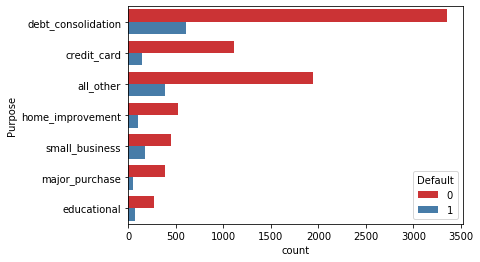

In [14]:
# Plot of Loans By Purpose
sb.countplot(y=loan.Purpose, hue=loan.Default, palette="Set1")
plt.show()
# Highest Not Paid Defaulters are those who took loan for DEBT_CONSOLDATION and the lowest is for MAJOR_PURCHASE

In [15]:
# Get the data ready for modelling. Drop the categorical variable after binarizing
loan = pd.concat([loan, pd.get_dummies(loan.Purpose)], axis=1)
loan = loan.drop('Purpose', axis=1)
loan.iloc[:,13:].tail(3)

,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
9575,0,0,1,0,0,0,0
9576,0,0,0,0,1,0,0
9577,0,0,1,0,0,0,0


### Decision Tree Classification using SKLearn

In [16]:
# Import relevant sklearn libs
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, auc

In [17]:
# Prepare parameters for modelling
y = loan['Default']
X = loan.drop(['Default'], axis=1)

# Stratified Sampling and Splitting
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, test_size=1/3, stratify=y, random_state=0)

# CrossValidation and GridSearch
param_grid = {'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':[x for x in range(1,6)]}
best_model = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv).fit(X,y)
print("Best Score : {:.3f}\nBest Params: {}".format(best_model.best_score_, best_model.best_params_))

Best Score : 0.840
Best Params: {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}


In [18]:
# This accuracy clearly is not the indicator of performance as the classes are very imbalanced (84/16)
# Therefore use a model with class weights
from sklearn.utils.class_weight import compute_class_weight
print('Class Weights:', compute_class_weight(class_weight='balanced', classes=y.unique().tolist(), y=y))
param_grid={'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':[1,2,3], 'class_weight':['balanced']}
best_model = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv).fit(X,y)
print("Best Score   : {:.3f}\nBest Params  : {}".format(best_model.best_score_, best_model.best_params_))

Class Weights: [0.59527657 3.12393999]
Best Score   : 0.759
Best Params  : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'splitter': 'best'}


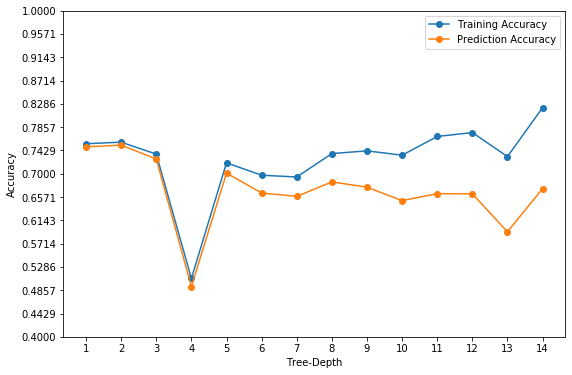

In [19]:
# Before building the final model - compare various tree sizes to get the best one
# Check and plot training and prediction accuracies to get the best tree-depth
train_acc = list()
test_acc = list()
n_range = np.arange(1,15,1)
for n,e in enumerate(n_range):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=e,class_weight='balanced',splitter='best').fit(X_train, y_train)
    train_acc.append(dt.score(X_train, y_train))
    test_acc.append(dt.score(X_test, y_test))
    #print('Depth = {:<2}, Train = {:.5f}, Test = {:.5f}'.format(e, train_acc[n], test_acc[n]))
    
# Plot the elbow curve to find train/test accuracy convergence and best tree-depth
plt.figure(figsize=(9,6))
plt.plot(n_range, train_acc, marker='o', label="Training Accuracy")
plt.plot(n_range, test_acc, marker='o', label="Prediction Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Tree-Depth")
plt.xticks(n_range)
plt.yticks(np.linspace(0.4,1,15))
plt.legend()
plt.show()

In [20]:
# Build the final model with the above result, criterion does not matter for this data-set
model_dt = DecisionTreeClassifier(criterion='entropy',splitter='best',class_weight='balanced',max_depth=3).fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
y_pred_prob = model_dt.predict_proba(X_test)[:,1]

print("Training Accuracy  : {:.3f}".format(model_dt.score(X_train, y_train)))
print("Testing Accuracy   : {:.3f}".format(model_dt.score(X_test, y_test)))
print('Prediction Accuracy:', round(accuracy_score(y_test, y_pred), 3))
print("Average CV Accuracy: %.3f" % cross_val_score(model_dt, X, y, cv=cv).mean())

Training Accuracy  : 0.736
Testing Accuracy   : 0.727
Prediction Accuracy: 0.727
Average CV Accuracy: 0.718


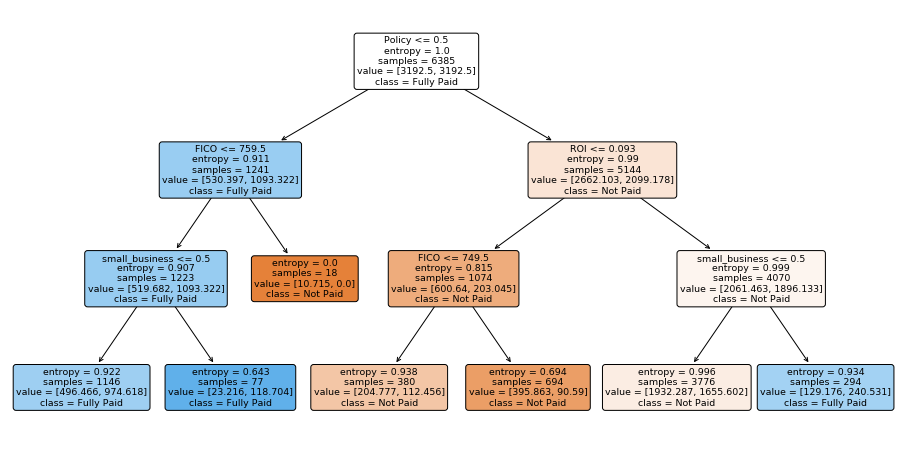

In [21]:
# Plot the decision tree path
plt.figure(figsize=(16,8))
plot_tree(model_dt, feature_names=X.columns, filled=True, rounded=True, class_names=['Not Paid','Fully Paid'])
plt.show()

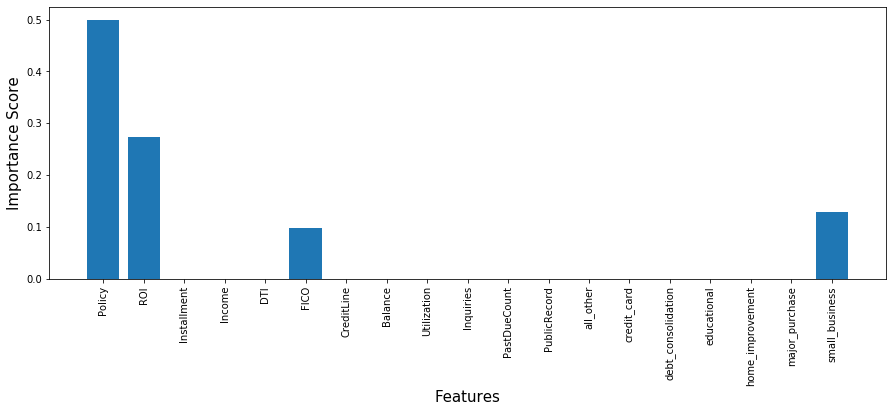

In [22]:
# We can also check the feature importances. From this we can see that Policy is the most important feature.
plt.figure(figsize=(15,5))
features = X.columns.shape[0]
plt.bar(range(features), model_dt.feature_importances_)
plt.xticks(np.arange(features), X, rotation=90)
plt.ylabel("Importance Score", size=15)
plt.xlabel("Features", size=15)
plt.show()

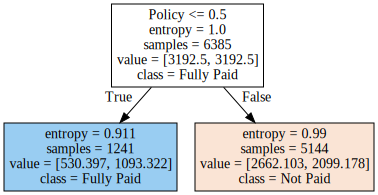

In [23]:
# In-fact the best model also happens to be a Decision-Stump (depth=1) with a matching accuracy.
# The stump is based on feature 'Policy' and as also seen from the elbow plot, depth 1,2,3 have similar accuracies
# Using Occam's Razor prinicple, it can be said that for the data-set, decision-stump based on Policy is the best model
import graphviz
model = DecisionTreeClassifier(criterion='entropy',max_depth=1,class_weight='balanced',splitter='best').fit(X_train, y_train)
graphviz.Source(export_graphviz(model, feature_names=X.columns, filled=True, class_names=['Not Paid','Fully Paid']))

## Evaluate Model Performance

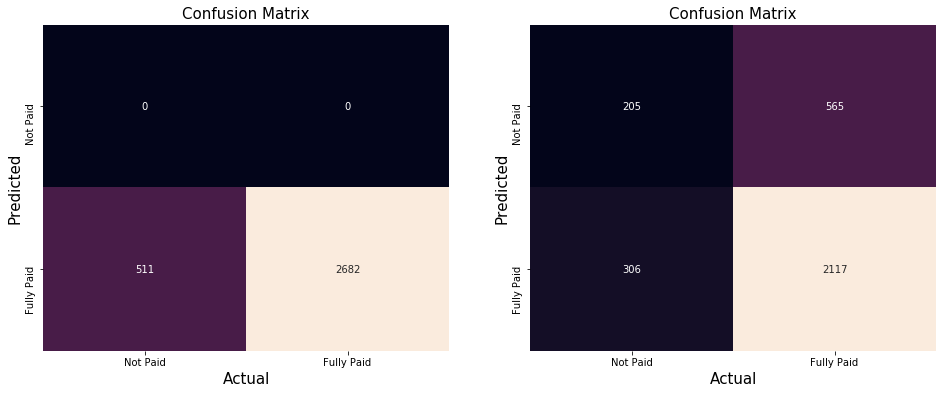

In [24]:
# Create another model to compare performance without class weights
# Comparatively, balanced weight model performs a lot better (better precision and recall for both 0/1 outputs)
model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3).fit(X_train, y_train)
y_pred1 = model.predict(X_test)
classes=['Not Paid', 'Fully Paid']
plt.figure(figsize=(16,6))
plt.subplot(121)
sb.heatmap(np.rot90(confusion_matrix(y_test,y_pred1),2).T,annot=True,fmt='d',xticklabels=classes,yticklabels=classes,cbar=False)
plt.xlabel('Actual', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix', size=15)
plt.subplot(122)
sb.heatmap(np.rot90(confusion_matrix(y_test, y_pred),2).T,annot=True,fmt='d',xticklabels=classes,yticklabels=classes,cbar=False)
plt.xlabel('Actual', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix', size=15)
plt.show()

In [25]:
# Print full classification report showing precision, recall, etc.
print('\033[1m\033[4m' + 'Report for Decision Tree Classifier\n' + '\033[0m')
print(classification_report(y_test, y_pred, digits=3, target_names=classes))

Report for Decision Tree Classifier

              precision    recall  f1-score   support

    Not Paid      0.874     0.789     0.829      2682
  Fully Paid      0.266     0.401     0.320       511

    accuracy                          0.727      3193
   macro avg      0.570     0.595     0.575      3193
weighted avg      0.776     0.727     0.748      3193

